# Small Language Models

Dieses Notebook untersucht mehrere neuronale Netzwerkarchitekturen für Sprachmodellierungsaufgaben. Die Modelle werden anhand einer künstlich generierten Sprache trainiert. Die Aufgabe bleibt dabei dieselbe: die Wahrscheinlichkeit des nächsten Wortes $Y$ anhand der vorherigen Wörter $X$ in einem Satz vorherzusagen.

$$
P(Y | X) 
$$

## Background and Motivation
Das Trainieren von Sprachmodellen anhand realer Sprachdaten erfordert oft umfangreiche Rechenressourcen, wie sie typischerweise in Rechenzentren zu finden sind. Um die grundlegenden Konzepte der Sprachmodellierung auf eine leichter zugängliche Weise zu erforschen, werden wir eine künstlich konstruierte Sprache verwenden. Dieser Ansatz ermöglicht es uns, die Komplexität zu kontrollieren, die zugrunde liegenden Mechanismen zu verstehen und die Ressourceneffizienz sicherzustellen.

## Ziele
Verstehen, Implementieren und Vergleichen verschiedener neuronaler Netzwerkarchitekturen (RNN, LSTM, Transformer) bei Sprachmodellierungsaufgaben unter Verwendung einer künstlich generierten Sprache.

## Aufgaben

### 1. **Artificial Language Generation for Training**:
Erstellen Sie einen initialen Datensatz an Sätzen unter Verwendung einer einfachen, regelbasierten Grammatik (siehe unten).

### 2. **Tokenization**:
Wandeln Sie diese Sätze in Folgen von ganzen Zahlen um.

### 3. **Model Building**: 
Implementieren Sie mindestens die ersten drei Modelle – ein grundlegendes RNN (erforderlich), ein LSTM (erforderlich), ein 1DCNN (erforderlich) und einen Transformer (optional).

### 4. **Training**:
Trainieren Sie jedes Modell anhand des Datensatzes für künstliche Sprachen und bewerten Sie die Leistung jedes Modells während des Trainings anhand des Validierungssatzes, indem Sie die Lernkurven für jedes Modell anzeigen und miteinander vergleichen.

Sie können den unten angegebenen Starter-Code verwenden, um loszulegen. Sie können den Code nach Belieben ändern. Die Architektur der Modelle können Sie selbst bestimmen, sie kann jedoch einfach sein. Für das RNN könnte sie beispielsweise wie folgt aussehen:

| Layer (type)            | Output Shape      | Param # |
|-------------------------|-------------------|---------|
| embedding_1 (Embedding) | (1, 35, 8)        | 208     |
| simple_rnn (SimpleRNN)  | (1, 50)           | 2,950   |
| dense (Dense)           | (1, 26)           | 1,275   |

Wichtig ist, eine geeignete Verlustfunktion für das nächste vorhergesagte Token zu wählen. Im obigen Beispiel beträgt die Vokabulargröße 25.

## Festlegen des Keras Backends

In [38]:
################# Keras with JAX Backend ################
##### We use the JAX backend for Keras
import jax 
print("jax version:\t", jax.__version__)

##### We set the KERAS_BACKEND environment variable to "jax"
import os
os.environ["KERAS_BACKEND"] = "jax"

##### We import Keras
import keras
print("keras version:\t", keras.__version__)

jax version:	 0.8.2
keras version:	 3.13.0


## Seltsame Sprache

Wir verwenden das folgende Verfahren, um Beispiele aus der Sprache zu generieren

In [39]:
import random
# Define the grammar rules
expanded_grammar = {
    'S': [['NP', 'VP'], ['S', 'CONJ', 'S']],
    'NP': [['Det', 'ADJ', 'N'], ['Det', 'N'], ['Det', 'N', 'PP']],
    'VP': [['V', 'NP'], ['V', 'NP', 'PP'], ['V', 'ADV']],
    'PP': [['P', 'NP']],
    'Det': ['a', 'the'],
    'N': ['cat', 'dog', 'bird', 'tree'],
    'V': ['sits', 'runs', 'flies', 'jumps'],
    'ADJ': ['big', 'small', 'quick', 'lazy'],
    'ADV': ['quickly', 'slowly', 'carefully'],
    'P': ['on', 'in', 'under', 'over'],
    'CONJ': ['and', 'but', 'or']
}

def generate_sentence(symbol, depth=0, max_depth=5):
    if depth > max_depth:  # Limiting recursion depth
        return ''

    if symbol not in expanded_grammar:
        return symbol

    expansion = random.choice(expanded_grammar[symbol])
    if isinstance(expansion, list):
        return ' '.join([generate_sentence(sym, depth+1, max_depth) for sym in expansion]).strip()
    else:
        return expansion

### Generierung von Trainings- und Testdaten 

Hier generieren wir die Trainings- und Testdaten für die Sprache. 

In [40]:
import random
import numpy as np
# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

# Generating sentences
num_train = 1000                        # Number of training examples
num_test  = 2000                        # Number of test examples
num_sentences = num_train + num_test    # Number of sentences to generate
sentences = [generate_sentence('S') for _ in range(num_sentences)]

# Sample some sentences
for i in range(5):
    print(f"{i} {sentences[i]}")

max_length = max(len(sentence.split()) for sentence in sentences)
print(f"\nmax_length of sentence: {max_length} words")
#print(len(sentences[0].split()))

0 the small dog sits a tree on a small cat
1 the dog under a lazy bird runs the big cat on the bird
2 the cat on the bird on runs slowly
3 a lazy bird flies the quick dog on a dog over
4 the cat on the bird runs the dog over but a dog flies carefully

max_length of sentence: 36 words


### Tokenisierung

Im Schritt „Tokenisierung” wandeln wir den eingegebenen Text in ganze Zahlen um. 

In [41]:
import numpy as np
import jax.numpy as jnp
from keras.layers import TextVectorization

# Define TextVectorization layer
vectorize_layer = TextVectorization(
    max_tokens=40, # Maximum vocabulary size (will be less)
    output_mode="int"
)

# Adapt the vectorization layer
vectorize_layer.adapt(sentences)

# Vectorize sentences (output is JAX-compatible)
sequences = vectorize_layer(sentences)
for i in range(5):
  print(f"sentence {i}: {sentences[i]}")
  print(f"sequence {i}: {sequences[i]}\n")

vocab_size = len(vectorize_layer.get_vocabulary())
print(f"\nvocab_size: {vocab_size}")

sentence 0: the small dog sits a tree on a small cat
sequence 0: [ 2 18  7 13  3  4 15  3 18  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]

sentence 1: the dog under a lazy bird runs the big cat on the bird
sequence 1: [ 2  7 16  3 22  5 12  2 20  6 15  2  5  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]

sentence 2: the cat on the bird on runs slowly
sequence 2: [ 2  6 15  2  5 15 12 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]

sentence 3: a lazy bird flies the quick dog on a dog over
sequence 3: [ 3 22  5 14  2 19  7 15  3  7 17  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]

sentence 4: the cat on the bird runs the dog over but a dog flies carefully
sequence 4: [ 2  6 15  2  5 12  2  7 17  9  3  7 14 25  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


vocab_size: 26


### Padding

Da der eingegebene Text eine variable Länge haben kann, wurde bei der Tokenisierung am Ende des Textes eine 0 hinzugefügt, um alle Texte auf die gleiche Länge zu bringen. Wir möchten jedoch, dass der Text mit einem echten Token endet. Deshalb nehmen wir die 0 am Ende und verschieben sie an den Anfang des Textes.

In [42]:
# Function to shift padding tokens to the beginning
def move_padding_to_front(sequence, padding_value=0):
    non_padding = sequence[sequence != padding_value]
    padding = sequence[sequence == padding_value]
    return jnp.concatenate([padding, non_padding])

# Apply the function to all sequences
adjusted_sequences = jnp.array([move_padding_to_front(seq) for seq in sequences])

# Print adjusted sequences
#print(adjusted_sequences[:4])
for i in range(5):
  print(f"sentence {i}: {sentences[i]}")
  print(f"sequence {i}: {sequences[i]}")
  print(f"adjusted {i}: {adjusted_sequences[i]}\n")
del(sequences)

sentence 0: the small dog sits a tree on a small cat
sequence 0: [ 2 18  7 13  3  4 15  3 18  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
adjusted 0: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2 18  7 13  3  4 15  3 18  6]

sentence 1: the dog under a lazy bird runs the big cat on the bird
sequence 1: [ 2  7 16  3 22  5 12  2 20  6 15  2  5  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
adjusted 1: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
  7 16  3 22  5 12  2 20  6 15  2  5]

sentence 2: the cat on the bird on runs slowly
sequence 2: [ 2  6 15  2  5 15 12 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
adjusted 2: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  2  6 15  2  5 15 12 24]

sentence 3: a lazy bird flies the quick dog on a dog over
sequence 3: [ 3 22  5 14  2 19  7 

### Training and Test Data
Der erste Teil der Sätze wird für Trainingsdaten verwendet, mit dem Ziel, das letzte Token des Satzes vorherzusagen.

Daher wird im Code mittels `[:,num_train, -1]` das letzte Token bzw. das letzte Wort aus dem Satz entfernt.
Anschließend wird wieder ein Trainings und ein Testset erstellt.

In [43]:
# Prepare X and y for training
x_train = adjusted_sequences[:num_train, :-1]
y_train = keras.utils.to_categorical(adjusted_sequences[:num_train, -1], num_classes=vocab_size)

# Prepare X_test and y_test
x_test = adjusted_sequences[num_train:, :-1]
y_test = keras.utils.to_categorical(adjusted_sequences[num_train:, -1], num_classes=vocab_size)

# Changes end here
# The first sentence
print(f"The first sentence :\'{sentences[0]}\'")
print(f"The first sentence after tokenization and padding :\n{adjusted_sequences[0]}")
print(f"The first sentence X for training (note the last token is missing):\n{x_train[0]}")
print(f"The first sentence Y for training (note that this is one-hot-encoded):\n{y_train[0]}") 

print()
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

The first sentence :'the small dog sits a tree on a small cat'
The first sentence after tokenization and padding :
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2 18  7 13  3  4 15  3 18  6]
The first sentence X for training (note the last token is missing):
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2 18  7 13  3  4 15  3 18]
The first sentence Y for training (note that this is one-hot-encoded):
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

Shape of x_train: (1000, 35)
Shape of y_train: (1000, 26)
Shape of x_test: (2000, 35)
Shape of y_test: (2000, 26)


Die Form der Daten bestätigt die oben gezeigten Werte.

Das `x`-Set hat dabei jeweils die Form `(N, max_len)` wobei `N` die Anzahl an Sätzen ist und `max_len` mit der oben ermittelten maximalen Satzlänge von 35 (höchste Anzahl Wörter in einem Satz) übereinstimmt.

Das `y`-Set hat die Form `(N, vocab_size)` wobei hier die `vocab_size` die oben ermittelte Anzahl verschiedener Wörter ist und mit 26 übereinstimmt.

### Shapes and Embeddings
`X` ist eine spärliche (*sparse*) Darstellung im Code. Anstatt die Token mit One-Hot-Coding zu kodieren, verwenden wir den Token-Index, d. h. jedes Wort/Token entspricht einem ganzzahligen Wert. Dies ist eine effizientere Darstellung der Daten, aber konzeptionell ist es dasselbe.

`Y` ist eine One-Hot-Kodierung mit der Form Batch, Vocabulary. Es handelt sich um das One-Hot-kodierte Ergebnis des nächsten Tokens. Beachten Sie, dass wir hier das **zuletzt vorhergesagte Wort** verwenden. Dies vereinfacht unseren Code, ist jedoch weniger effizient. In technischen Umsetzungen wird auch das Wort für alle $t=1..T$ als Ziel verwendet.

In unserem oben gezeigten Beispiel beträgt die Vokabulargröße 26. In unserem Trainingssatz `X` wurde das zu ermittelnde Wort "cat" entfernt. Dies hatte einen Token von 6. Daher ist `Y` in diesem Fall eine One-Hot-Kodierung mit einer 1 an der 6. Position.

#### Embedding layer
Der erste Schritt, den wir von $X(B,T,V)$ zu $X(B,T,C)$ durchführen, ist die Einbettungsschicht (*Embedding-Layer*). Dabei handelt es sich um eine einfache Matrixmultiplikation. Die Größe der Einbettungsschicht `C` ist ein Hyperparameter. 

In [44]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

EMB_DIM = 8  # Embedding dimension (a.k.a. C)
EPOCHS = 50
BATCH_SIZE = 64
# Define the model
emb_model = Sequential()
emb_model.add(Embedding(vocab_size, EMB_DIM)) 
### 
# <---- Add your model here ---->
###

# Predict embeddings for the input data
embeddings = emb_model.predict(x_test)  # x_test is already prepared as input sequences
print(f"Shape {embeddings.shape} (Batch, Time, Embedding)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Shape (2000, 35, 8) (Batch, Time, Embedding)


Ausgehend von der Einbettungsschicht oben können wir nun RNN, LSTM, 1DCNN oder Transformer anwenden.
Für die einzelnen Modelle wird eine Plotfunktion definiert mit welcher die Accuracy und der Loss der jeweiligen Modelle dargestellt werden, später werden die Modelle auch noch gegeneinander verglichen.

In [45]:
#### Plotfunktion
import matplotlib.pyplot as plt

def plot_learning_curves(history, title="Learning Curves"):
    """
    history: dict mit Schlüsseln
        'val_accuracy', 'val_loss'
    """
    plt.figure(figsize=(6,4))
    plt.plot(history["val_accuracy"], label="Validation Accuracy")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (NLL)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

#### Verlustfunktion (*Loss-Function*)
Zur Vorhersage des nächsten Tokens wurde die kategoriale Kreuzentropie (`categorical_crossentropy`) verwendet. Diese entspricht der negativen Log-Likelihood eines kategorialen probabilistischen Modells und ist damit eine geeignete Verlustfunktion für Sprachmodelle.

Was wir ja eigentlich machen, ist die Vorhersage des nächsten Tokens. Die Modelle sagen also eine Wahrscheinlichkeitsverteilung über das Vokabular voraus $$p_\theta(y \mid x)$$
wobei
- $y$ das nächste Token ist
- $x$ die bisherige Token-Sequenz ist

Für unsere One-Hot-kodierte Zielvariable $y$ ergibt sich die Verlustfunktion also als: 
$$\mathcal{L} = -\log(p_\theta(y_\text{true} \mid x))$$
Das Modell wird also bestraft, wenn es dem richtigen nächsten Token eine niedrige Wahrscheinlichkeit gibt. Je sicherer das Modell ist, desto kleiner ist dann auch der Loss.

____

### RNN

> Ein Recurrent Neural Network (RNN) ist ein neuronales Netz zur Verarbeitung von Sequenzdaten, bei dem Informationen aus früheren Zeitschritten über einen versteckten Zustand weitergegeben werden.
>
> Bei jedem Zeitschritt $t$: $$h_t = f(h_{t-1}, x_t)$$
> - $x_t$: aktuelles Eingabe-Token
> - $h_{t-1}$: vorheriger Zustand (Gedächtnis)
> - $h_t$: neuer Zustand, der Information über die gesamte bisherige Sequenz enthält
>
> Das RNN „liest“ eine Sequenz Token für Token ein wobei der versteckte Zustand $h_t$ eine komprimierte Zusammenfassung der Vergangenheit darstellt. Dadurch kann das Modell Abhängigkeiten in Sequenzen modellieren (z.B. Sprache, Zeitreihen).
>
> Ein einfaches RNN leidet unter dem Vanishing-Gradient-Problem, wodurch lange Abhängigkeiten schlecht gelernt werden (wir haben ja aber nur maximal 35 Wörter in einem Satz, ist also ein überschaubarer kontext).

Mit dem `return_sequence=False` wird sichergestellt, dass das RNN nur den letzten Zeitschritt zurück gibt und nicht wie oben beschrieben das Wort für alle $t=1,\dots,T$ zurück gibt.

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

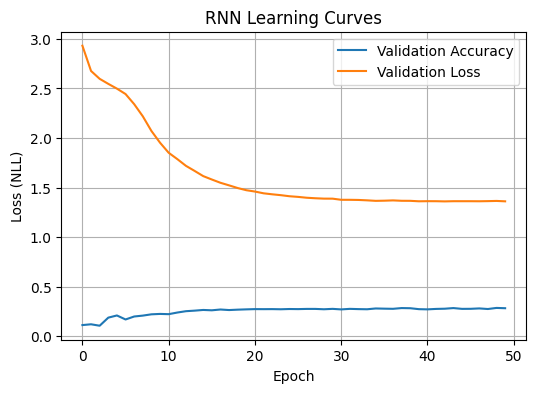

In [46]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

EMB_DIM = 8

# define model
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, EMB_DIM))           # word-token -> 8 dimensional Vector as representation   
rnn_model.add(SimpleRNN(50, return_sequences=False))    # 50 = sice of hidden state input: (B,T,C) -> output: (B,50)
rnn_model.add(Dense(vocab_size, activation="softmax"))  # output: (B, vocabsize) = (B, 26) as probability distribution

# complie model
rnn_model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

rnn_model.summary()

# fit model
history = rnn_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0
)

plot_learning_curves(history.history, title="RNN Learning Curves")

In [47]:
embeddings = rnn_model.predict(x_test)  # x_test is already prepared as input sequences
print(f"Shape {embeddings.shape} (Batch, Time, Embedding)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Shape (2000, 26) (Batch, Time, Embedding)


### LSTM

> Ein LSTM (Long Short-Term Memory) ist eine spezielle Form eines RNN, die Informationen über längere Zeiträume speichern kann.
>
> Im Gegensatz zum einfachen RNN entscheidet das LSTM aktiv,
> - was es behalten
> - was es vergessen
> - was es weitergeben soll
>
> Dadurch wird das Vanishing-Gradient-Problem stark reduziert.

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

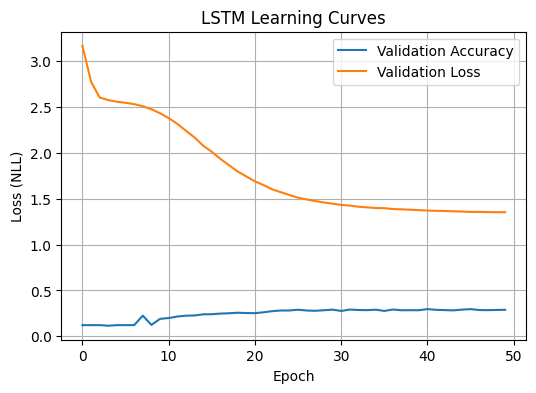

In [48]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

EMB_DIM = 8

# define model
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, EMB_DIM))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(vocab_size, activation="softmax"))

# compile model
lstm_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

lstm_model.summary()

# fit model
history_lstm = lstm_model.fit(
    x_train,        # (B, T)
    y_train,        # (B, Vocabulary)
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    verbose=0
)

plot_learning_curves(history_lstm.history, title="LSTM Learning Curves")

In [49]:
embeddings = lstm_model.predict(x_test)  # x_test is already prepared as input sequences
print(f"Shape {embeddings.shape} (Batch, Time, Embedding)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Shape (2000, 26) (Batch, Time, Embedding)


### 1DCNN

> Ein 1D-Convolutional Neural Network (1D-CNN) verarbeitet Sequenzen, indem es mit Filtern über die Zeitachse gleitet und dabei lokale Muster (z.B. n-Gramme) erkennt.
>
> Im Gegensatz zu RNNs:
> - keine Rekurrenz
> - kein Zustand
> - Kontext wird explizit über Faltungsfenster modelliert
>
> Zentrale Idee:
> - Ein Filter schaut z.B. auf 3 benachbarte Wörter
> - Lernt typische Wortfolgen
> - Mehrere Filter → verschiedene Muster
> - Tiefe CNNs → größerer Kontext

Die Parameter des 1D-CNN wurde durch mehrfaches testen wie folgt festgelegt:
- `kernel_size` = $3$
- `dilation_rate` = $2^n$ mit $n = 0, 1, \dots, 4$

Die `kernel_size` gibt dabei an wie viele Zeitschritte bzw. Gewichte in jedem Schritt angeschaut werden.

Die `dilation_rate` gibt an, wie viele Zeitschritte "übersprungen" werden.
Im ersten Layer (dilation = 1) sieht der Kernel demnach die Zeitschritte `[t-2] [t-1] [t]`, im darauffolgenden Layer (dilation = 2) also die Zeitschritte `[t-4] [t-2] [t]`.

Aus den getesteten und unten im Code dargestellten definitionen, ergibt sich ein 1DCNN welches sich wie folgt darstellen lässt:
![1DCNN.drawio](figure/1DCNN.drawio.png)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_66 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_68 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_69 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_10         │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

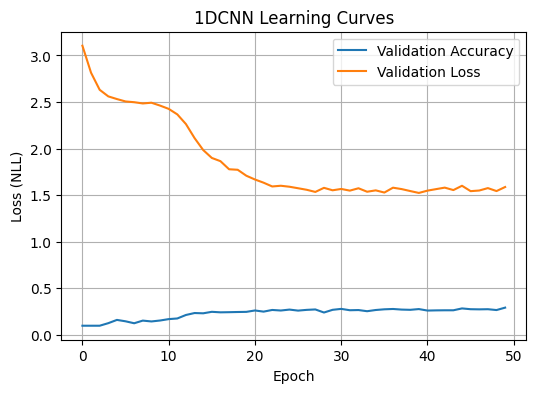

In [50]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Lambda

EMB_DIM = 8
KERNEL_SIZE = 3

# define model
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, EMB_DIM))
cnn_model.add(Conv1D(filters=vocab_size,kernel_size=KERNEL_SIZE, activation='relu', padding='causal', dilation_rate=1))
cnn_model.add(Conv1D(filters=vocab_size,kernel_size=KERNEL_SIZE, activation='relu', padding='causal', dilation_rate=2))
cnn_model.add(Conv1D(filters=vocab_size,kernel_size=KERNEL_SIZE, activation='relu', padding='causal', dilation_rate=4))
cnn_model.add(Conv1D(filters=vocab_size,kernel_size=KERNEL_SIZE, activation='relu', padding='causal', dilation_rate=8))
cnn_model.add(Conv1D(filters=vocab_size,kernel_size=KERNEL_SIZE, activation='relu', padding='causal', dilation_rate=16))
#cnn_model.add(Conv1D(vocab_size, 3, activation='relu', padding='causal', dilation_rate=32))

# aggregation over the time axis
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(vocab_size, activation="softmax"))
#cnn_model.add(Lambda(lambda x: x[:, -1, :]))

# compile model
cnn_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()

# fit model
history_cnn = cnn_model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    verbose=0
)

plot_learning_curves(history_cnn.history, title="1DCNN Learning Curves")

In [51]:
embeddings = rnn_model.predict(x_test)  # x_test is already prepared as input sequences
print(f"Shape {embeddings.shape} (Batch, Time, Embedding)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Shape (2000, 26) (Batch, Time, Embedding)


### Vergleich der Modelle

Zu Schluss wird noch wie in der Aufgabe gefordert ein vergleich der Genauigkeit für alle drei Modelle erstellt.

Wichtig ist hierbei aber, dass die Accuracy eigentlich **keine proper scoring rule** für Sprachmodelle ist, wurde hier aber so gefordert.

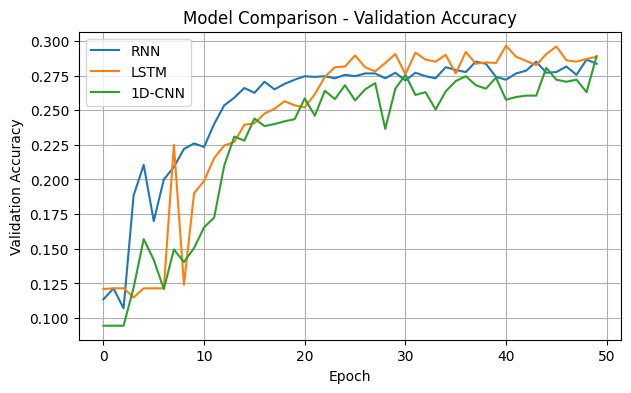

In [52]:
plt.figure(figsize=(7,4))
plt.plot(history.history["val_accuracy"], label="RNN")
plt.plot(history_lstm.history["val_accuracy"], label="LSTM")
plt.plot(history_cnn.history["val_accuracy"], label="1D-CNN")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison - Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()